In [5]:
# install the gradient-boosting
!pip install lightgbm

In [6]:
# import essential packages
import os, math, warnings
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,4)

In [7]:
# load the dataset
# read the datapath
data_path = "E:\SEP6DA3\Lab1_student"
train_csv = os.path.join(data_path, 'train.csv')
# define the type of variable for each specific column in order to save size
dtypes = {'id':'object','vendor_id' : 'int8','passenger_count':'int8', 
 'pickup_longitude':'float32','pickup_latitude':'float32', 
 'dropoff_longitude':'float32','dropoff_latitude':'float32', 
 'store_and_fwd_flag':'object','trip_duration':'int32'}
df = pd.read_csv(train_csv, dtype = dtypes, parse_dates = ['pickup_datetime','dropoff_datetime'])
print("Loaded shape:", df.shape) 

Loaded shape: (1458644, 11)


In [8]:
# in order to improve the efficiency, use the sampling, I use other parameters for testing
df = df.sample(frac=0.4, random_state=35).reset_index(drop=True)

In [9]:
# feature engineering for the date/time
df['pickup_hour'] = df['pickup_datetime'].dt.hour.astype('int8')
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek.astype('int8')
df['pickup_month'] = df['pickup_datetime'].dt.month.astype('int8')

In [10]:
# Haversine distance 
# Calculate the shortest distance (i.e., the geographical straight-line distance) between two points on the spherical surface based on latitude and longitude.
def haversine_distance(lat1, lon1, lat2, lon2): 
 R=6371.0 
 phi1,phi2=np.radians(lat1),np.radians(lat2) 
 dphi=np.radians(lat2-lat1) 
 dl=np.radians(lon2-lon1) 
 a=np.sin(dphi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(dl/2)**2 
 return 2*R*np.arcsin(np.sqrt(a))


In [11]:
# generate the new column for the distance, finding the distance between the starting point and the destination
df['distance_km'] = haversine_distance(df['pickup_latitude'],df['pickup_longitude'], df['dropoff_latitude'],df['dropoff_longitude']).astype('float32')

# set and create the new feature -- average speed feature
df['speed_kmph'] = df['distance_km'] / (df['trip_duration']/3600 + 1e-9) # 1e-9 is for the abnormal case when trip_duration is zero
df['speed_kmph'] = df['speed_kmph'].clip(upper=200) # clip for the upper boundary 200 is to ensure that we can remove the abnormal cases


In [12]:
# select features and target
features = ['pickup_hour','pickup_dayofweek','pickup_month',
            'distance_km','speed_kmph','passenger_count']
X = df[features].fillna(-1) # use -1 to fill the missing values in order to make the model prediction effective
y = df['trip_duration']
y_log = np.log1p(y)  # log-transform to handle skew

In [13]:
# set the size of the train/test data
# in this case, I will use 7:3 to separate train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=35)

In [14]:
# baseline for the lightBGM model training
# use the lightBGM model specific data storage method in order for more efficient processing
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [15]:
# parameters modulation
# for adjustment, I use leaves = 45, learning_rate = 0.05
params = {
    'objective':'regression',     # regression
    'metric':'rmse',              # RSME evluation on log
    'learning_rate':0.05,          # smaller rate, more rounds
    'num_leaves':45,              # more leaves might lead to overfitting
    'verbosity':-1,                
    'seed':35                     
}

In [16]:
# train the model
# I will use num_boost_round = 300, eartly_stopping = 30
model=lgb.train(params,train_data,num_boost_round=300,valid_sets=[valid_data], 
                callbacks=[lgb.early_stopping(30),lgb.log_evaluation(0)]) 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 0.156385


In [17]:
# evaluate the model
y_pred_log=model.predict(X_test,num_iteration=model.best_iteration) # use the rounding of tree model with the best prediction result

# transfer the unit of log back to unit of second in time
y_test_orig=np.expm1(y_test)
y_pred_orig=np.expm1(y_pred_log) 


Baseline LightGBM MAE: 31.11 sec, RMSE: 747.41 sec


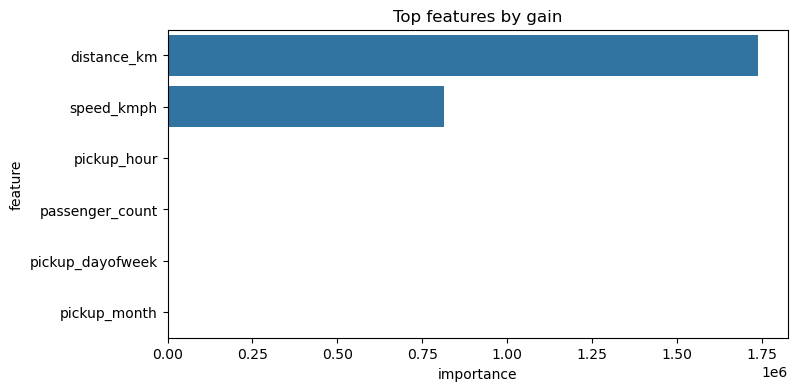

In [18]:
# find the mean absolute error MAE
mae=mean_absolute_error(y_test_orig,y_pred_orig)
# find the root mean squared error RMSE
rmse=math.sqrt(mean_squared_error(y_test_orig,y_pred_orig)) 

print(f"Baseline LightGBM MAE: {mae:.2f} sec, RMSE: {rmse:.2f} sec") 

# investigate and figure out the importance of each feature using visualization
# Feature importance plot 
imp=pd.DataFrame({'feature':model.feature_name(), 
 'importance':model.feature_importance('gain')}).sort_values('importance',ascending=False) 
sns.barplot(x='importance',y='feature',data=imp.head(10)) 
plt.title("Top features by gain") 
plt.show() 


In [21]:
# 3Vs of data exploration
# volume
print("\n=== 3Vs of Big Data Exploration ===") 
print("\n[Volume] Simulating different sample sizes...")
for frac in [0.05,0.25,0.5,1.0]: 
    subset=df.sample(frac=frac,random_state=42) 
    print(f" frac={frac:.2f} → rows={subset.shape[0]}") 

# velocity
print("\n[Velocity] Reading CSV in small chunks (first 3)...") 
chunk_iter=pd.read_csv(train_csv,dtype=dtypes, 
 parse_dates=['pickup_datetime','dropoff_datetime'], 
 chunksize=50000) 
for i,chunk in enumerate(chunk_iter): 
 print(f" Chunk {i+1} shape: {chunk.shape}") 
 if i==2: break 

# Variety
print("\n[Variety] Adding synthetic external data...") 
weather_df=pd.DataFrame({'pickup_date':pd.date_range( 
 start=df['pickup_datetime'].min().normalize(), 
 end=df['pickup_datetime'].max().normalize(),freq='D')}) 
np.random.seed(42) 
weather_df['rain_flag']=np.random.randint(0,2,size=len(weather_df)).astype('int8') 
df_w=df.copy() 
df_w['pickup_date']=pd.to_datetime(df_w['pickup_datetime']).dt.normalize() 
df_w=df_w.merge(weather_df,how='left',on='pickup_date') 
print(df_w[['pickup_datetime','rain_flag']].head()) 



=== 3Vs of Big Data Exploration ===

[Volume] Simulating different sample sizes...
 frac=0.05 → rows=29173
 frac=0.25 → rows=145864
 frac=0.50 → rows=291729
 frac=1.00 → rows=583458

[Velocity] Reading CSV in small chunks (first 3)...
 Chunk 1 shape: (50000, 11)
 Chunk 2 shape: (50000, 11)
 Chunk 3 shape: (50000, 11)

[Variety] Adding synthetic external data...
      pickup_datetime  rain_flag
0 2016-03-21 11:22:05          0
1 2016-04-26 10:38:33          0
2 2016-06-17 23:07:31          0
3 2016-05-12 09:05:53          0
4 2016-03-26 10:30:11          0
